# GMRES metoda

Iterační posloupnost je sestavována tak, že $x_i$ minimalizuje $||r_i||$ na prostoru $K_i(b)$.

In [1]:
using SparseArrays
using LinearAlgebra
using PyPlot

In [2]:
function poisson_problem(n)
    A = sparse(4.0*I, n*n, n*n)
    for x=1:n
        for y=1:n
            i = x + (y-1)*n
            if x>1 A[i,i-1] = -1.0 end
            if x<n A[i,i+1] = -1.0 end
            if y>1 A[i,i-n] = -1.0 end
            if y<n A[i,i+n] = -1.0 end
        end
    end
    b = ones(n*n)/(n*n)
    return A,b
end

poisson_problem (generic function with 1 method)

In [3]:
A,b = poisson_problem(20);

In [4]:
function GMRES(A, b, x0; maxiters=100, tol=1e-6)

    function apply_givens_rotations!(h,c,s,k)
        for i=1:k-2
            tmp = cs[i]*h[i] + sn[i]*h[i+1]
            h[i+1] = -sn[i]*h[i] + cs[i]*h[i+1]
            h[i] = tmp
        end
        
        if h[k-1]==0.0
            cs[k-1] = 0.0
            sn[k-1] = 1.0
        else
            tmp=sqrt(h[k]^2+h[k-1]^2)
            cs[k-1] = abs(h[k-1]) / tmp
            sn[k-1] = cs[k-1] * h[k] / h[k-1]
        end
        
        h[k-1] = cs[k-1]*h[k-1] + sn[k-1]*h[k]
        h[k] = 0.0
    end
    
    n = size(b,1)
    m = maxiters
    
    r = b - A*x0
    
    r_norm = norm(r)
    b_norm = norm(b)
    
    rezid = [r_norm/b_norm]
    
    H = zeros(m+1,m)
    V = zeros(n,m+1)
    V[:,1] = r/r_norm
    cs = zeros(m)
    sn = zeros(m)
    β = zeros(m+1)
    β[1] = r_norm
    
    k1=0
    for k=2:maxiters+1
        k1 = k-1
        
        # Arnoldi proces
        V[:,k] = A*V[:,k-1]
        for j=1:k-1
            H[j,k-1] = dot(V[:,j], V[:,k])
            V[:,k] -= H[j,k-1]*V[:,j]
        end
        H[k,k-1] = norm(V[:,k])
        V[:,k] /= H[k,k-1]
        
        # Eliminace posledniho elementu pomoci Givensovych rotaci
        apply_givens_rotations!(view(H,1:k,k-1),cs,sn,k)
        
        
        β[k]   = -sn[k-1]*β[k-1];
        β[k-1] = cs[k-1]*β[k-1];
   
        error = abs(β[k]) / b_norm
        append!(rezid, error)    
    
        if error <= tol break end
    end
    
    y = H[1:k1,1:k1] \ β[1:k1]
    x = x0 + V[:,1:k1]*y
    return (solution=x, reziduals=rezid)
        
end

GMRES (generic function with 1 method)

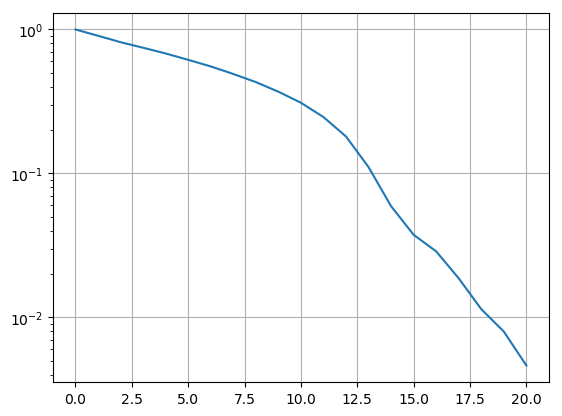

In [6]:
x0 = zeros(size(b,1))
gm = GMRES(A,b,x0,maxiters=20)
semilogy(gm.reziduals); grid(true);

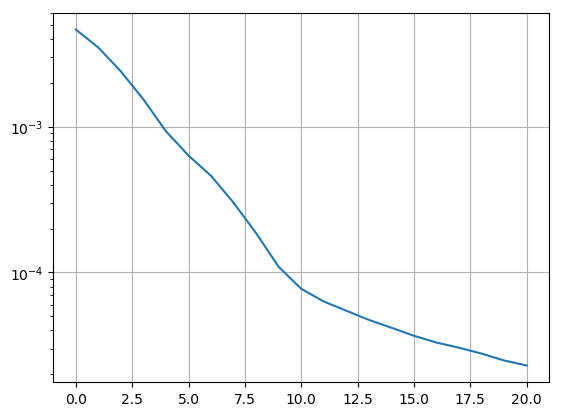

In [7]:
x = copy(gm.solution)
gm1 = GMRES(A,b,x,maxiters=20);
semilogy(gm1.reziduals); grid(true);

In [8]:
function GMRESR(A, b, x0; restart=20, maxiters=100, tol=1e-8)
    x = copy(x0)
    rezid = zeros(0)
    while size(rezid,1)<maxiters
        sol = GMRES(A, b, x, maxiters=restart, tol=tol)
        x = sol.solution
        append!(rezid, sol.reziduals)
        if rezid[end] < tol break end
    end
    return (solution=x, reziduals=rezid)
end     

GMRESR (generic function with 1 method)

In [9]:
x0 = zeros(size(b,1))
gmr10 = GMRESR(A,b,x0,restart=10);

In [10]:
gmr20 = GMRESR(A,b,x0,restart=20);

In [11]:
gmr40 = GMRESR(A,b,x0,restart=40);

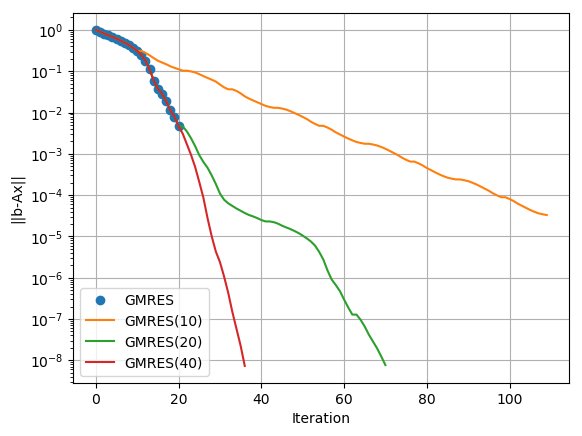

In [12]:
semilogy(gm.reziduals, "o", label="GMRES");
semilogy(gmr10.reziduals, label="GMRES(10)");
semilogy(gmr20.reziduals, label="GMRES(20)");
semilogy(gmr40.reziduals, label="GMRES(40)");
xlabel("Iteration"); ylabel("||b-Ax||"); 
grid(true); legend(loc="lower left");

In [13]:
A250, b250 = poisson_problem(250);
x0250=zeros(size(b250,1));

In [14]:
gmr250_10 = GMRESR(A250,b250,x0250,restart=10);

In [15]:
gmr250_20 = GMRESR(A250,b250,x0250,restart=20);

In [16]:
gmr250_40 = GMRESR(A250,b250,x0250,restart=40);

In [18]:
gmr250_80 = GMRESR(A250,b250,x0250,restart=80);

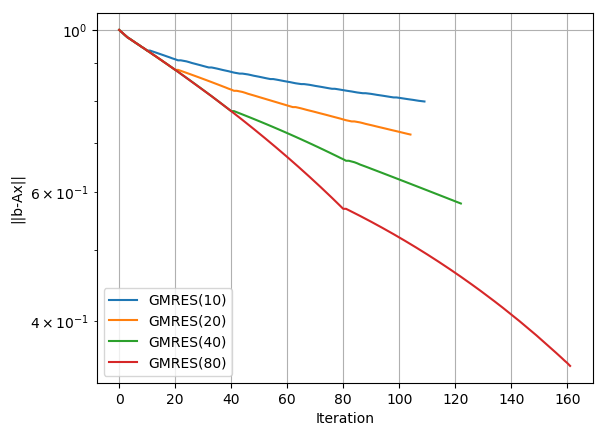

In [19]:
semilogy(gmr250_10.reziduals, label="GMRES(10)");
semilogy(gmr250_20.reziduals, label="GMRES(20)");
semilogy(gmr250_40.reziduals, label="GMRES(40)");
semilogy(gmr250_80.reziduals, label="GMRES(80)");
xlabel("Iteration"); ylabel("||b-Ax||"); 
grid(true); legend(loc="lower left");